# Heart Disease Classification

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from utils import *

In [2]:
filename = 'heart_cleveland_upload.csv'
df = pd.read_csv(filename)

print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  


In [3]:
# Show basic info
print(df.info())  # Check for missing values and data types
print(df.describe())  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.1

### Histograms

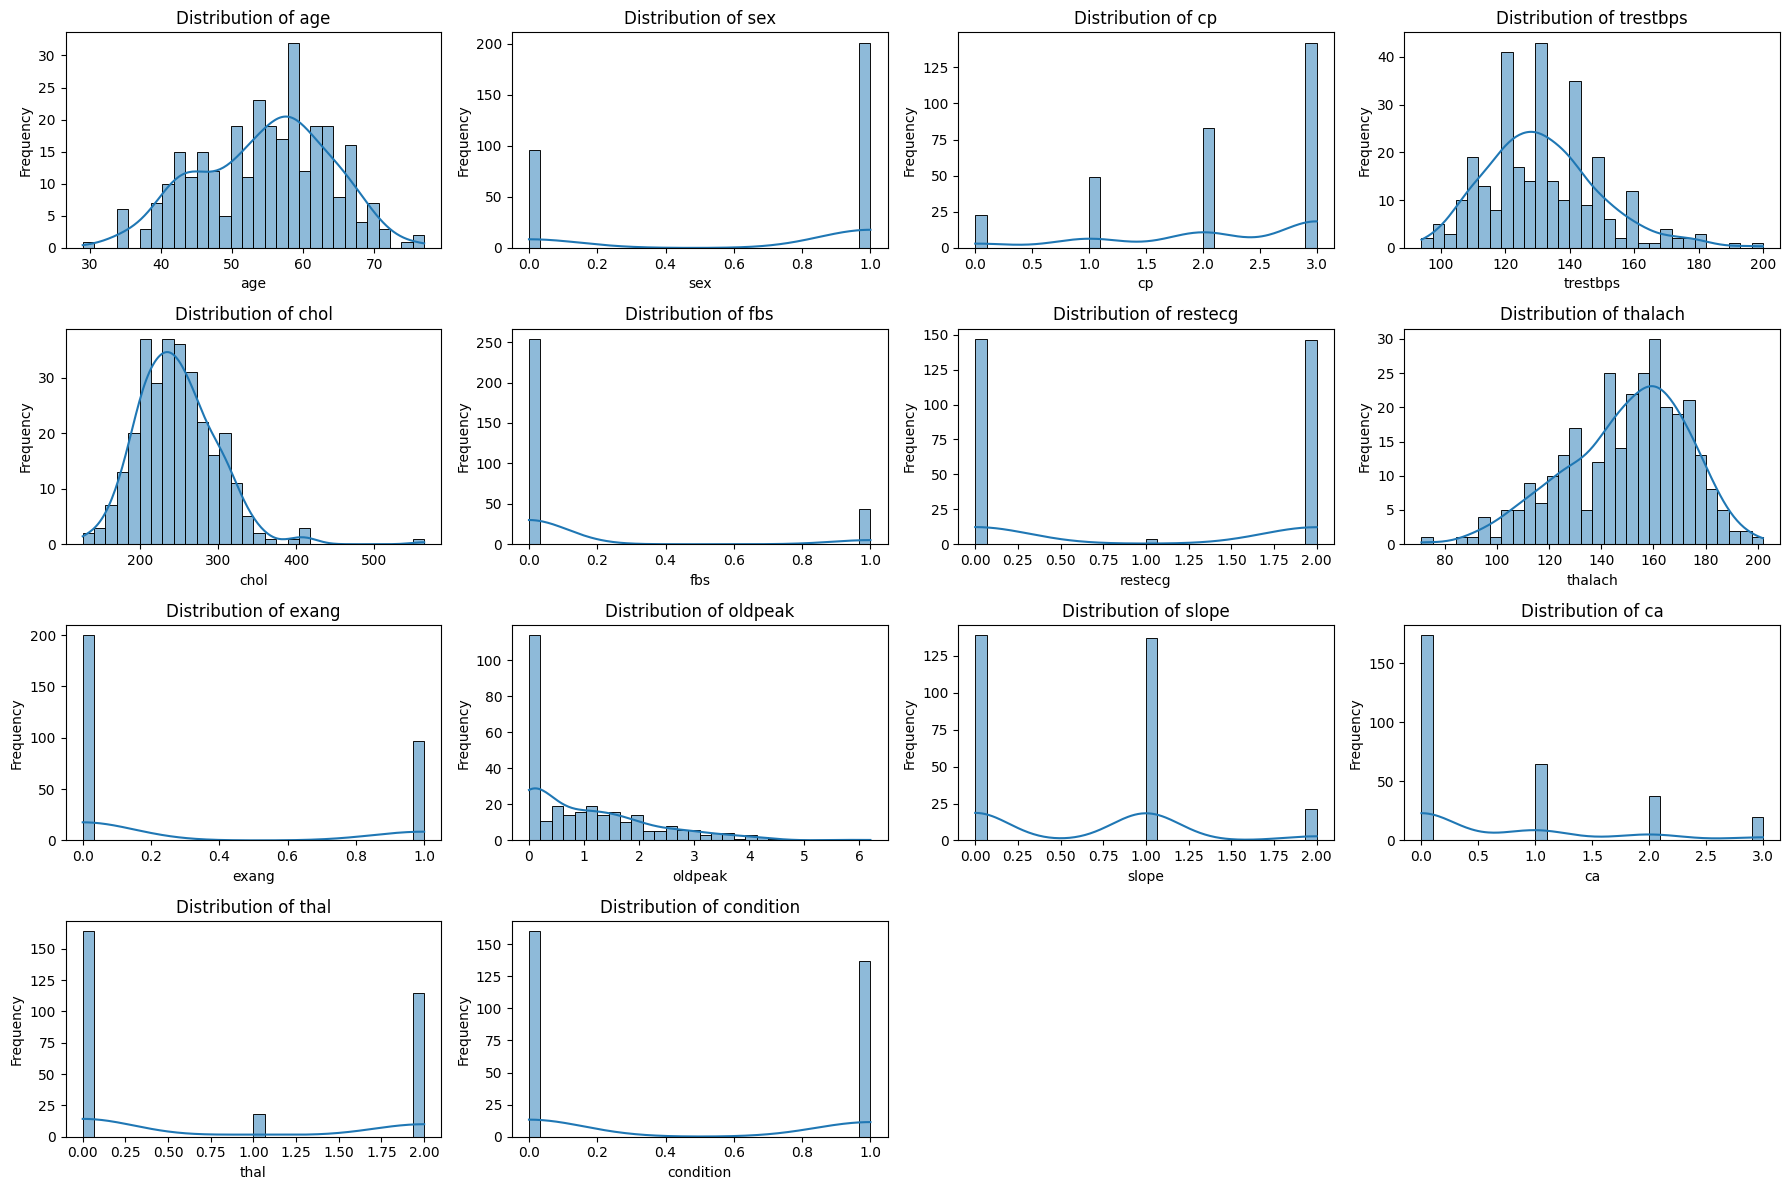

In [4]:
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [5]:
df = pd.get_dummies(df, drop_first=True)  # One-hot encoding

In [6]:
print(df['thal'])

0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
294    2
295    0
296    2
Name: thal, Length: 297, dtype: int64


### Split data into Train and Test Set

In [7]:
# separate data from labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(X.head())
print()
print(y.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  
0   1     0  
1   2     0  
2   0     0  
3   1     0  
4   0     0  

0    0
1    0
2    0
3    1
4    0
Name: condition, dtype: int64


In [8]:
# Split data into train and test set: 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(f"Training Set:       X_train={X_train.shape},    y_train={y_train.shape}")
print(f"Test Set:           X_test={X_test.shape},      y_test={y_test.shape}")

Training Set:       X_train=(237, 13),    y_train=(237,)
Test Set:           X_test=(60, 13),      y_test=(60,)


## All models

In [10]:
model_names = ('Logistic Regression', 'SVM', 'Neural Network')
best_models = []

## Logistic Regression

### Grid search to find the best parameter C

In [11]:
log_reg = LogisticRegression(solver='liblinear', max_iter=300)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X_train, y_train)

best_log_reg = grid_search.best_estimator_
best_models.append(best_log_reg)
print("Best C from GridSearchCV:", grid_search.best_params_['C'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best C from GridSearchCV: 0.1


### Metrics (Classification Report, Confusion Matrix and ROC Curve)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.70      0.75      0.72        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60




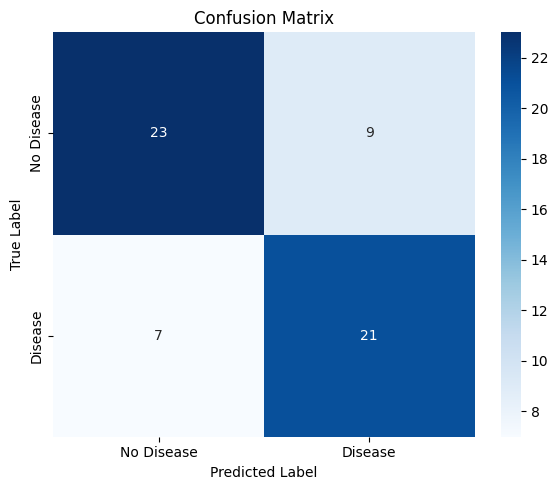

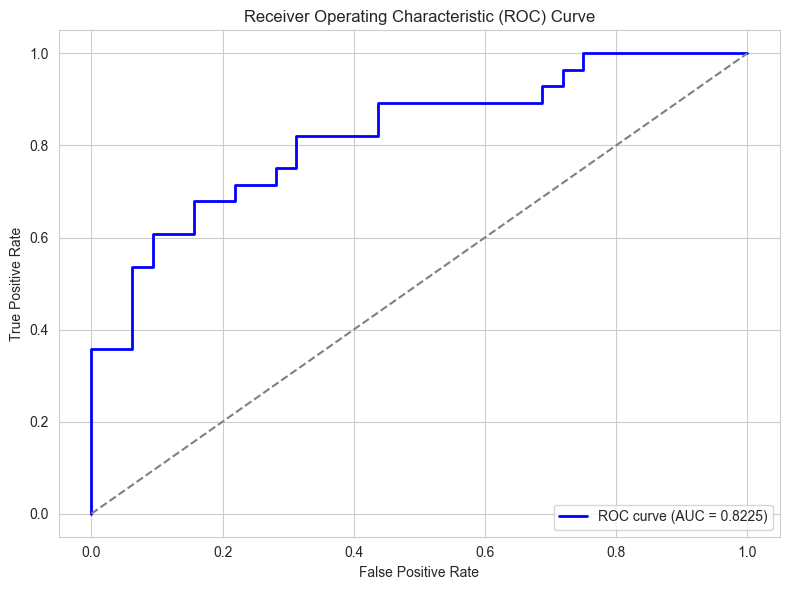

In [12]:
print_metrics(best_log_reg, X_test, y_test)

## Support Vector Machine

### Grid search to find the best parameters

In [13]:
svc = SVC(probability=True)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']      # for rbf
}

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
best_models.append(best_svm)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
# best_svm = SVC(C=10, kernel='linear', probability=True)
# best_svm.fit(X_train, y_train)
# best_models.append(best_svm)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        32
           1       0.68      0.75      0.71        28

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        60




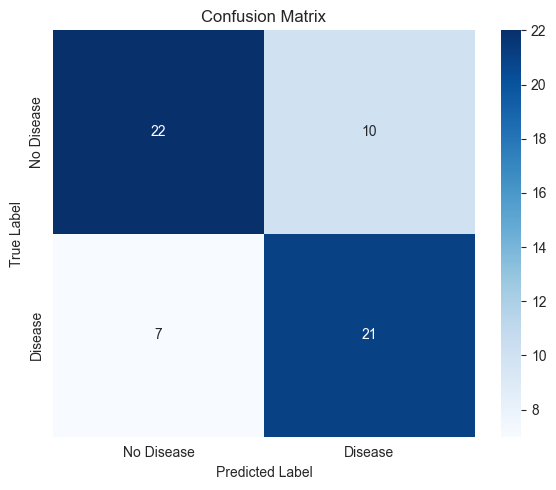

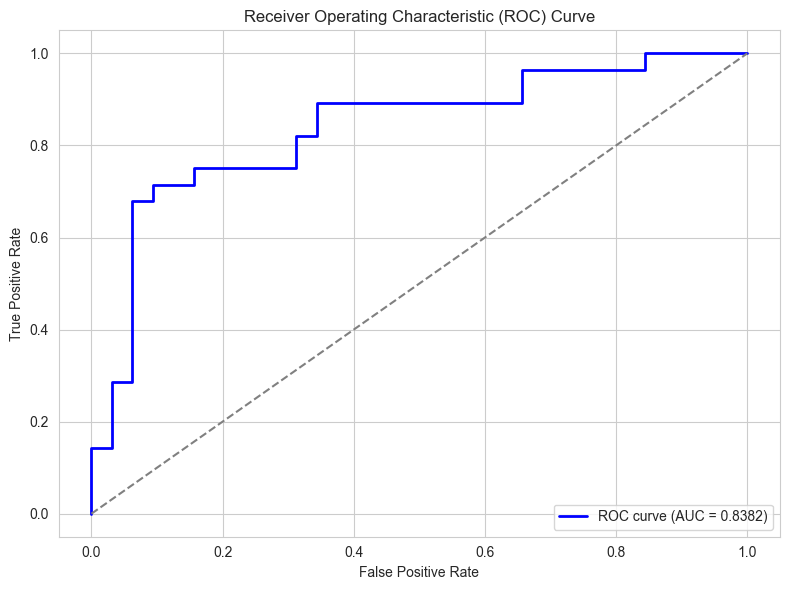

In [ ]:
print_metrics(best_svm, X_test, y_test)

## Random Forest

## KNN

## XGBoost

## Neural Network

### Architecture

In [ ]:
def build_model(lr=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(12, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    return model

### Grid search to find the best parameters

In [ ]:
lr_values = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [8, 16, 32, 64]
epochs_list = [50, 100, 150, 200] 

# Prepare the KFold cross-validation
X_train = np.array(X_train)
y_train = np.array(y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_params = {}

for lr, batch_size, epochs in product(lr_values, batch_sizes, epochs_list):
    fold_accuracies = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model = build_model(lr=lr)
        model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, verbose=0)
        
        y_pred_fold = (model.predict(X_val_fold) > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        fold_accuracies.append(accuracy)
    
    mean_accuracy = np.mean(fold_accuracies)
    
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

print("Best Parameters:", best_params)

### Metrics (Classification Report, Confusion Matrix and ROC Curve)

In [ ]:
best_nn = build_model(lr=best_params['lr'])
best_nn.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)
best_models.append(best_nn)

print_metrics(best_nn, X_train, y_train)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       128
           1       0.73      0.86      0.79       109

    accuracy                           0.79       237
   macro avg       0.80      0.80      0.79       237
weighted avg       0.80      0.79      0.79       237




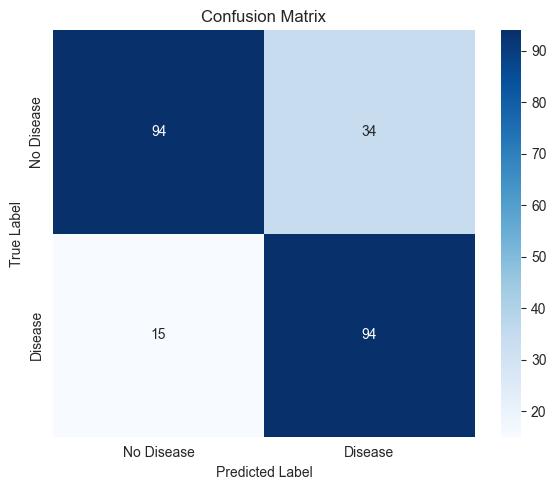

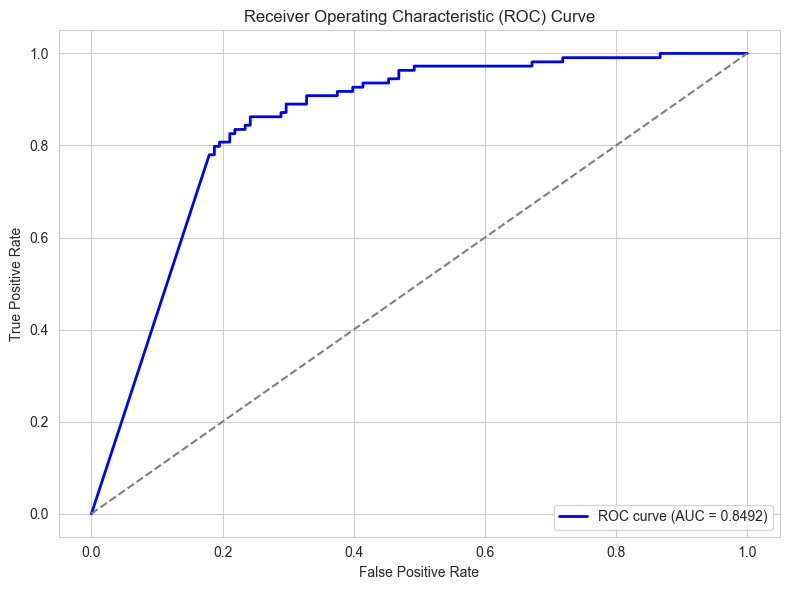

In [ ]:
# best_nn = build_model(lr=0.001)
# best_nn.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
# best_models.append(best_nn)

# print_metrics(best_nn, X_train, y_train)